# **Tenor Saxophone Pitch Recognition Using Self-Generated Data Collected from Novocaine**

In [1]:
# Imports for handling data and ML model development & execution
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchaudio.transforms as T

# Imports for fetching from MongoDB
from motor.motor_asyncio import AsyncIOMotorClient

# Standard library imports
import random
from typing import List, Dict, Tuple, Any
from collections import defaultdict

: 

## **1: Initial Data Exploration**

In [ ]:
# MongoDB client setup with database name of `mydatabase` 
mongo_client: AsyncIOMotorClient = (
    AsyncIOMotorClient("mongodb://localhost:27017")
)
db = mongo_client.mydatabase

In [3]:
async def fetch_data_as_dict() -> List[Dict[str, Any]]:
    """
    Fetches data from MongoDB and converts it into a list of dictionaries.
    Each dictionary contains 'label' and 'raw_audio' keys with their associated values.

    Returns
    -------
    List[Dict[str, Any]]
        A list of dictionaries with the data from MongoDB.
    """
    cursor = db.labeledinstances.find({})
    data_points = await cursor.to_list(length=None)

    # Format data into the desired dictionary format
    formatted_data = [
        {"label": dp["audio_label"], "raw_audio": np.array(dp["raw_audio"])} 
        for dp in data_points
    ]

    return formatted_data

data = await fetch_data_as_dict()
print(data[:5])

[{'label': '3', 'raw_audio': array([-0.16214935, -0.15185943, -0.14287607, ..., -0.1286917 ,
       -0.12608966, -0.10967185])}, {'label': '3', 'raw_audio': array([-0.08239092, -0.04676696, -0.00696686, ...,  0.01975179,
        0.00954282,  0.00588135])}, {'label': '3', 'raw_audio': array([ 0.00822771,  0.01419222,  0.02322077, ..., -0.2854104 ,
       -0.27270475, -0.2598957 ])}, {'label': '3', 'raw_audio': array([-0.24492933, -0.22666857, -0.21097824, ..., -0.02646803,
       -0.06225394, -0.09305842])}, {'label': '3', 'raw_audio': array([-0.11609806, -0.12462123, -0.1162662 , ...,  0.01934203,
        0.02786646,  0.03840829])}]


In [12]:
# Organize data by label
data_by_label = defaultdict(list)

for item in data:
    data_by_label[item["label"]].append(item["raw_audio"])

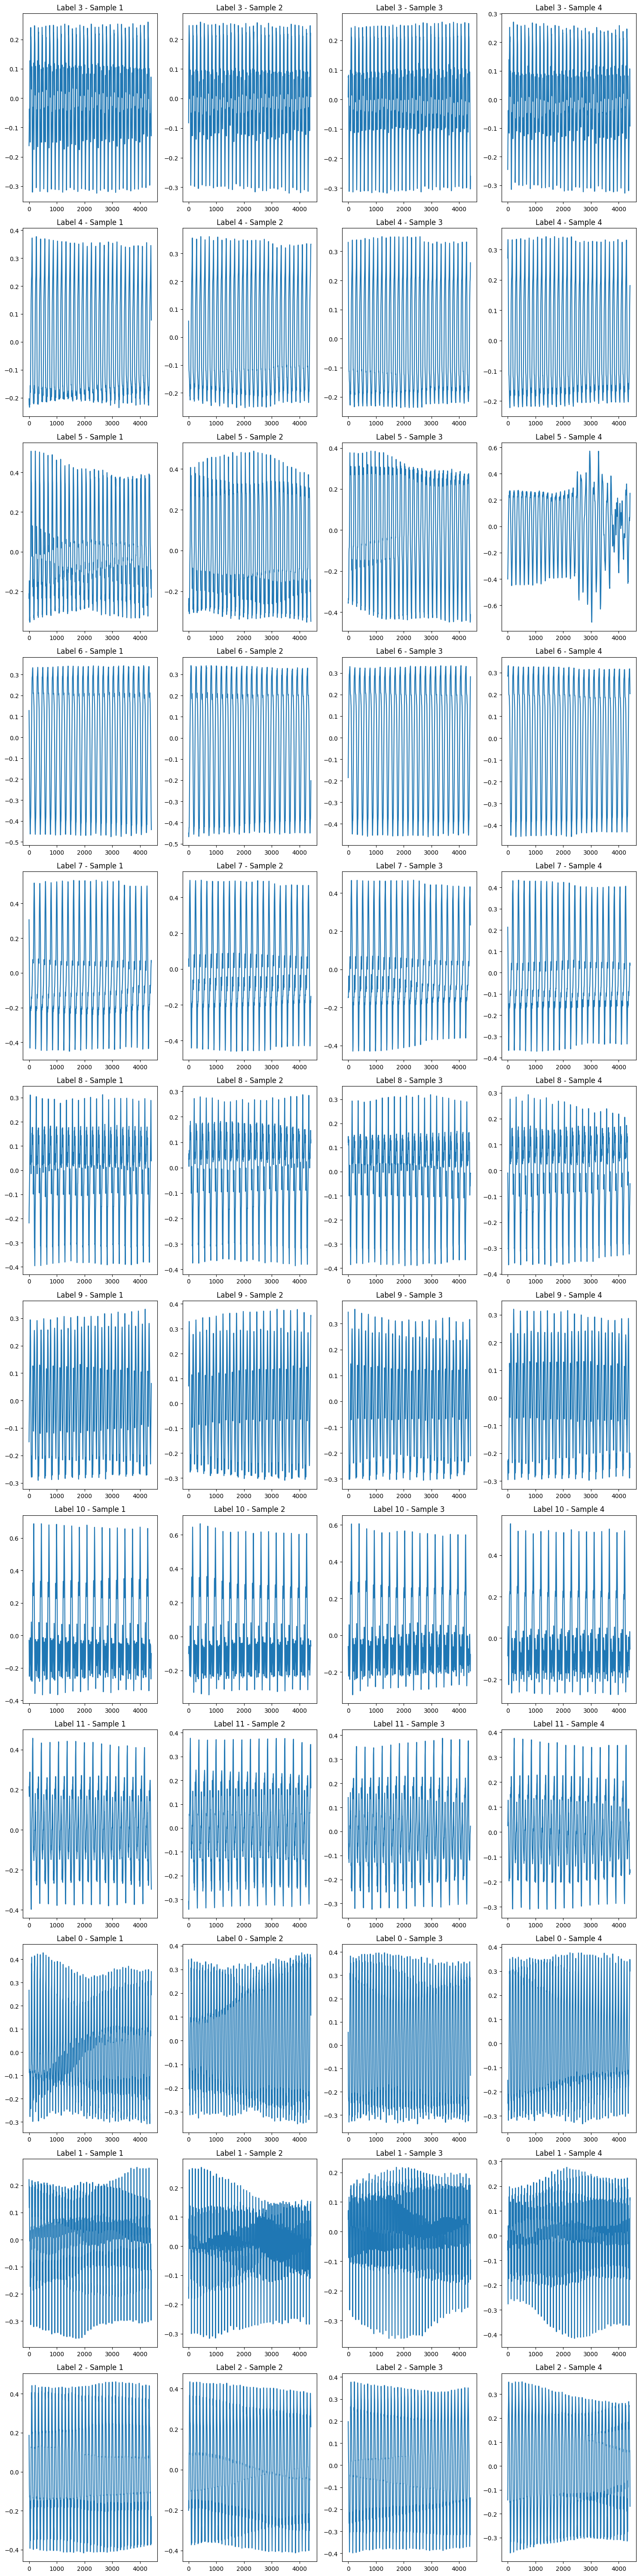

In [13]:
# Number of plots per label
plots_per_label = 4

# Calculate the total number of subplots needed
num_labels = len(data_by_label)
total_plots = num_labels * plots_per_label

# Determine the size of the grid
rows = num_labels
cols = plots_per_label

# Create a large figure
plt.figure(figsize=(15, 5 * rows))

# Plotting
plot_number = 1
for label, waves in data_by_label.items():
    for i in range(plots_per_label):
        # Select a wave distribution
        wave = waves[i % len(waves)]  # This modulo operation handles cases with fewer than 4 waves

        # Create subplot
        plt.subplot(rows, cols, plot_number)
        plt.plot(wave)
        plt.title(f'Label {label} - Sample {i+1}')

        plot_number += 1

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Take the FFT of each individual audio buffer.

In [14]:
# Apply FFT using PyTorch and update data_by_label
for label, raw_audios in data_by_label.items():
    fft_audios = []
    for raw_audio in raw_audios:
        # Convert raw audio to a PyTorch tensor
        tensor_audio = torch.tensor(raw_audio)

        # Apply FFT - PyTorch's FFT returns a complex tensor
        fft_audio = torch.fft.fft(tensor_audio)

        # Store the FFT result (you can store it as complex or convert to magnitude)
        fft_audios.append(fft_audio)

    # Update the data_by_label with FFT data
    data_by_label[label] = fft_audios

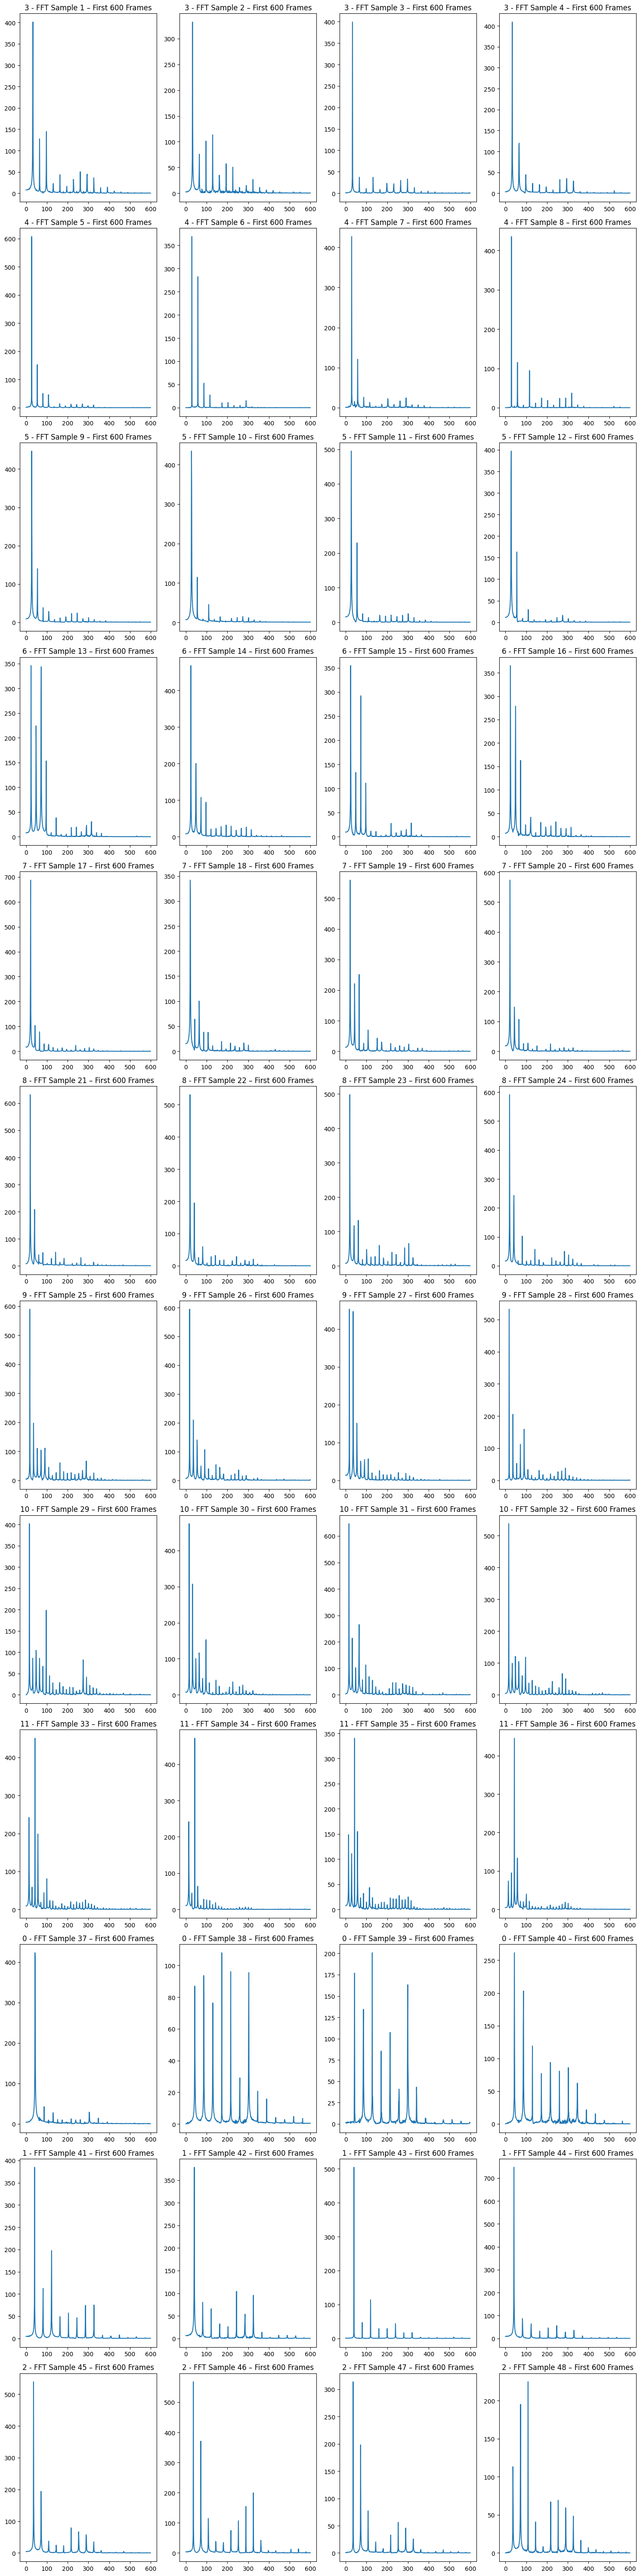

In [28]:
# Set the number of random samples per label
samples_per_label = 4

# Determine the size of the grid for subplots
num_labels = len(data_by_label)
cols = samples_per_label
rows = num_labels

# Create a large figure
plt.figure(figsize=(15, 5 * rows))

# Plotting
plot_number = 1
for label, fft_audios in data_by_label.items():
    # Randomly select 'samples_per_label' FFTs
    selected_ffts = random.sample(fft_audios, min(samples_per_label, len(fft_audios)))

    for fft_audio in selected_ffts:
        # Calculate the magnitude of the FFT
        magnitude_fft_audio = torch.abs(fft_audio).numpy()

        # Create subplot for the magnitude of the first 600 frames of the FFT
        plt.subplot(rows, cols, plot_number)
        plt.plot(magnitude_fft_audio[:600])
        plt.title(f'{label} - FFT Sample {plot_number} – First 600 Frames')
        plot_number += 1

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## **2: Convert Audio Data to Mel Spectrogram**

In [50]:
def convert_to_pytorch_dataset(
    data_points: List[Dict],
    one_hot_encoder: OneHotEncoder,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Convert the list of data points to PyTorch Tensors for features and labels.
    """
    # Extract Mel Spectrogram features for CNN
    features_list = []
    mel_spectrogram_transform = T.MelSpectrogram(
        sample_rate=44100,
        n_fft=4410,  # This can be adjusted based on the desired time resolution
        win_length=None,  # Window length, can be set to n_fft by default
        hop_length=200,  # This controls the overlap between frames; adjust as needed
        n_mels=256,  # Number of Mel filters
    ) 
    
    # Iterate through datapoints and apply Mel Spectrogram Transform on each raw audio buffer
    for dp in data_points:
        waveform = torch.tensor(dp["raw_audio"]).float().view(1, -1)
        mel_spectrogram = mel_spectrogram_transform(waveform)
        mel_spectrogram = mel_spectrogram.view(1, mel_spectrogram.size(1), mel_spectrogram.size(2))
        features_list.append(mel_spectrogram)
    
    # Declare list to store all labels
    labels_list = [dp["label"] for dp in data_points]

    # One-hot encode labels
    labels_encoded = one_hot_encoder.transform(np.array(labels_list).reshape(-1, 1))
    labels_encoded_tensor = torch.tensor(labels_encoded)  # Convert NumPy array to PyTorch tensor

    # Convert one-hot encoded labels to class indices for the CrossEntropyLoss
    labels_indices = torch.argmax(labels_encoded_tensor, dim=1)

    features = torch.stack(features_list)
    labels = labels_indices

    return features, labels


# Identify labels for One-Hot-Encoding 
possible_labels = np.array([str(i) for i in np.arange(12)])
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(possible_labels.reshape(-1, 1))

# Extract Mel Spectrogram for each audio buffer and associated notes label
mel_features, audio_labels = convert_to_pytorch_dataset(
    data_points=data, 
    one_hot_encoder=one_hot_encoder,
)

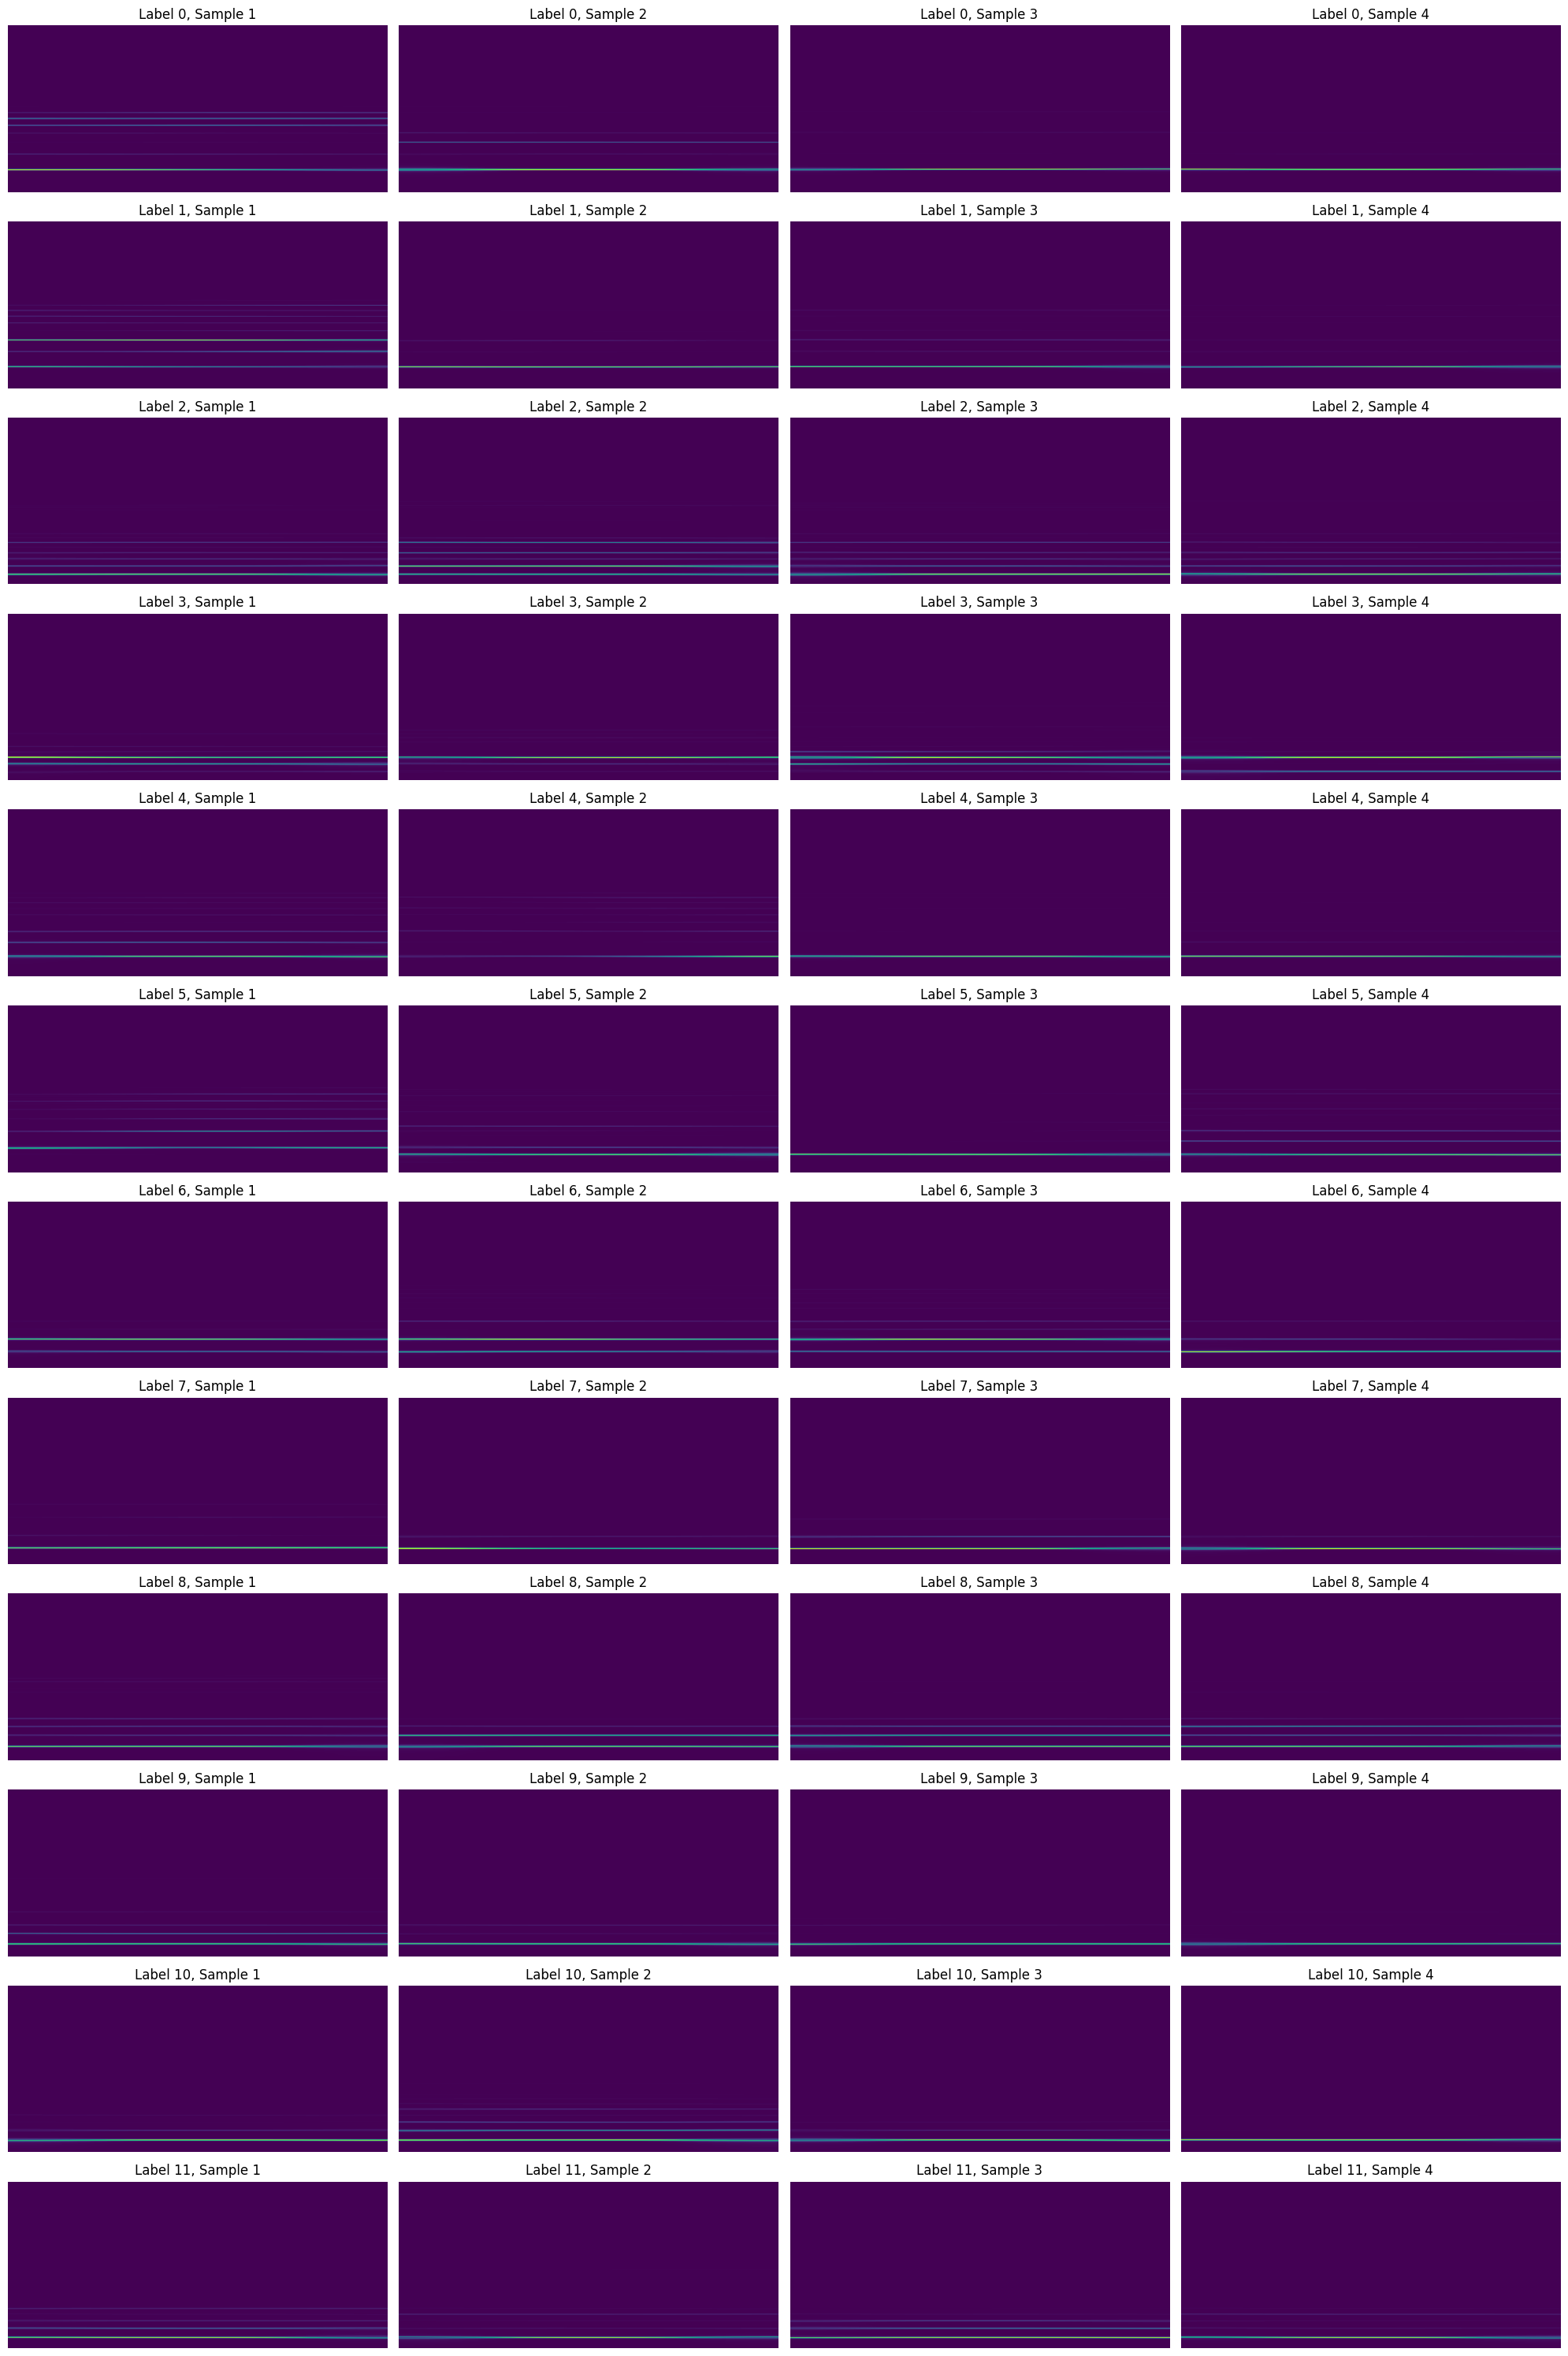

Total Data Count: 5220
Mel Spectrogram Size:  (256, 23)


In [51]:
# Function to plot 4 random audio buffers for each label
def plot_mel_spectrograms(mel_features, audio_labels):
    fig, axs = plt.subplots(12, 4, figsize=(20, 30))
    for label in range(12):
        indices = np.where(audio_labels == label)[0]
        random_indices = np.random.choice(indices, 4, replace=False)
        for i, idx in enumerate(random_indices):
            mel_spec = mel_features[idx].squeeze().numpy()
            axs[label, i].imshow(mel_spec, aspect='auto', origin='lower')
            axs[label, i].set_title(f"Label {label}, Sample {i+1}")
            axs[label, i].axis('off')
    plt.tight_layout()
    plt.savefig("plots/mel_spectrograms.png")
    plt.show()

# Plotting the Mel Spectrograms
plot_mel_spectrograms(mel_features, audio_labels)

# Output Total Amount of Data that we have
total_data_size: int = len(mel_features)
print(f"Total Data Count: {total_data_size}")

# Write Shape of Mel Spectrograms
mel_spec_size: Tuple[int, int] = mel_features[0].squeeze().numpy().shape
print("Mel Spectrogram Size: ", mel_spec_size)

## **3: Train Mel Spectrogram Convolutional Neural Network**

In [4]:
class MelSpectrogramCNN(nn.Module):
    def __init__(self, n_mels=256, n_fft=4410, win_length=None, hop_length=200, sample_rate=44100, n_classes=12):
        super(MelSpectrogramCNN, self).__init__()
        # Define Mel Spectrogram layer
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            n_mels=n_mels,
        )
        
        # Define a small CNN for demonstration purposes
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Number of pooling layers
        num_pool_layers = 3

        # After each pooling layer with kernel size 2, the size is halved
        # Initial size is [32, 1, 256, 23]
        conv_output_height = n_mels // (2**num_pool_layers)  # After pooling layers
        conv_output_width = 23 // (2**num_pool_layers)  # After pooling layers
        
        # Calculate the correct number of flattened features after the conv and pooling layers
        # Number of output channels from the last conv layer is 64
        flattened_size = 64 * conv_output_height * conv_output_width
        self.fc1 = nn.Linear(flattened_size, 500)
        self.fc2 = nn.Linear(500, n_classes)

    def forward(self, data):
        # Ensure input data is of type float (torch.float32)
        waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(1) 

        # Convert waveform to Mel Spectrogram
        mel_spectrogram = self.mel_spectrogram(waveform)
        
        # Pass through CNN layers
        x = self.pool(F.relu(self.conv1(mel_spectrogram)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor for the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Now, put the raw audio data into features and labels numpy arrays.

In [5]:
# Assuming 'data' is a list of dictionaries with 'raw_audio' and 'label' keys
data_by_label = defaultdict(list)

# Organize data by label
for item in data:
    data_by_label[item["label"]].append(item["raw_audio"])

# Now we convert the organized data into separate features and labels numpy arrays
features = []
labels = []

for label, audios in data_by_label.items():
    for audio in audios:
        features.append(audio)
        labels.append(int(label))

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape  :", labels.shape)

Features shape: (5220, 4410)
Labels shape  : (5220,)


/var/folders/s0/2zhm09_j1y99mpf7ky4y82km0000gn/T/ipykernel_94077/4284303781.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  waveform = torch.tensor(data, dtype=torch.float32).unsqueeze(1)


Epoch [1/25], Train Loss: 6.8842, Val Loss: 0.1347, Accuracy: 98.47%
Epoch [2/25], Train Loss: 0.0912, Val Loss: 0.1069, Accuracy: 99.14%
Epoch [3/25], Train Loss: 0.0928, Val Loss: 0.1591, Accuracy: 99.52%
Epoch [4/25], Train Loss: 0.0416, Val Loss: 0.1301, Accuracy: 99.33%
Epoch [5/25], Train Loss: 0.0448, Val Loss: 0.1260, Accuracy: 99.52%
Epoch [6/25], Train Loss: 0.0695, Val Loss: 0.0820, Accuracy: 99.33%
Epoch [7/25], Train Loss: 0.0567, Val Loss: 0.1516, Accuracy: 99.43%
Epoch [8/25], Train Loss: 0.0366, Val Loss: 0.0931, Accuracy: 99.04%
Epoch [9/25], Train Loss: 0.1990, Val Loss: 3.4269, Accuracy: 90.42%
Epoch [10/25], Train Loss: 0.5490, Val Loss: 0.6852, Accuracy: 99.52%
Epoch [11/25], Train Loss: 0.0821, Val Loss: 0.1835, Accuracy: 99.62%
Epoch [12/25], Train Loss: 0.0245, Val Loss: 0.1868, Accuracy: 99.71%
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch [13/25], Train Loss: 0.0153, Val Loss: 0.2359, Accuracy: 99.81%
Epoch [14/25], Train Loss: 0.0168, Va

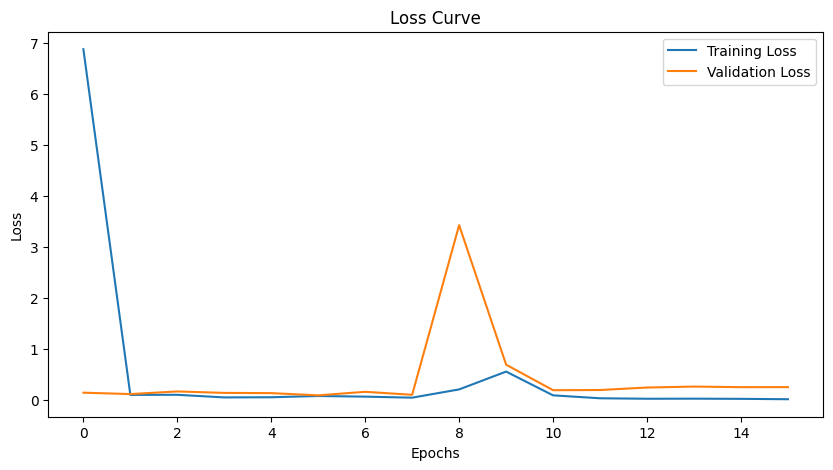

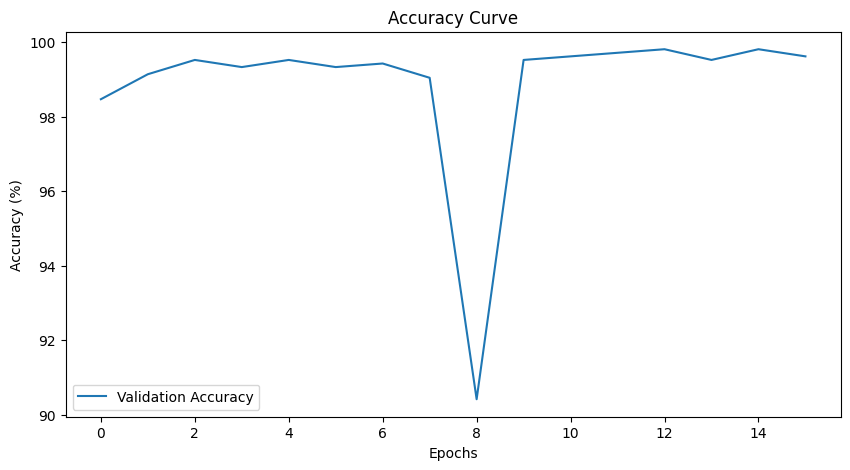

In [95]:
# Split the dataset into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, random_state=42,
)

# Create Tensor datasets for training and test sets
train_dataset = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
test_dataset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

# Create DataLoaders for both sets
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instantiate the model
model = MelSpectrogramCNN()

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)

# Lists to keep track of losses and accuracies
train_losses = []
val_losses = []
accuracies = []

# Parameters for early stopping
early_stopping_patience = 10
early_stopping_counter = 0
best_loss = float('inf')

# Training loop with early stopping
num_epochs = 25
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    train_loss = running_loss / len(train_loader)
    val_loss /= len(test_loader)
    accuracy = 100 * correct / total
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Record losses & accuracy for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    
    # Learning rate scheduler step
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), './pytorch_model/mel_spectrogram_cnn.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Stopping early!")
            break

# Save the model
torch.save(model.state_dict(), './pytorch_model/mel_spectrogram_cnn.pth')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve') 
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

## **4: Convert PyTorch Mel Spectrogram CNN to Apple CoreML**

In [ ]:
# Load the trained PyTorch model
model = MelSpectrogramCNN()
model.load_state_dict(torch.load('./pytorch_model/mel_spectrogram_cnn.pth'))

In [4]:
# Load the trained PyTorch model into eval mode
model.eval()

: 

In [ ]:
# Create some dummy input data that matches the model's input shape
# The input to the MelSpectrogramCNN model is raw audio data
dummy_input = torch.rand(1, 1, 4410)  # Batch size of 1, 1 channel, 4410 samples

In [ ]:
# Trace the model with a dummy input
traced_model = torch.jit.trace(model, dummy_input)

In [ ]:
# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.TensorType(shape=dummy_input.shape)],  # Define the input type
)

In [ ]:
# Save the Core ML model
mlmodel.save('../xcode/Saxophone-Hero/CoreML/MelSpectrogramCNN.mlmodel')